In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scanpy as sc
import progeny
import pandas as pd
from statsmodels.stats.multitest import multipletests
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy_helpers as sh
import scipy
import altair as alt

sc.set_figure_params(figsize=(5, 5))

## Load data

In [3]:
adata = sc.read_h5ad("../../data/30_merge_adata/adata_scvi.h5ad")
artifact_dir = "../../data/70_downstream_analyses/gene_expression"

In [4]:
!mkdir -p {artifact_dir}

In [5]:
adata.obs.columns

Index(['patient', 'timepoint', 'sample', 'n_genes_by_counts', 'total_counts',
       'total_counts_mito', 'pct_counts_mito', 'n_counts', 'n_genes',
       'patient_id', 'sex', 'age', 'ethnicity', 'response', 'leiden',
       'leiden_scvi', 'cell_type'],
      dtype='object')

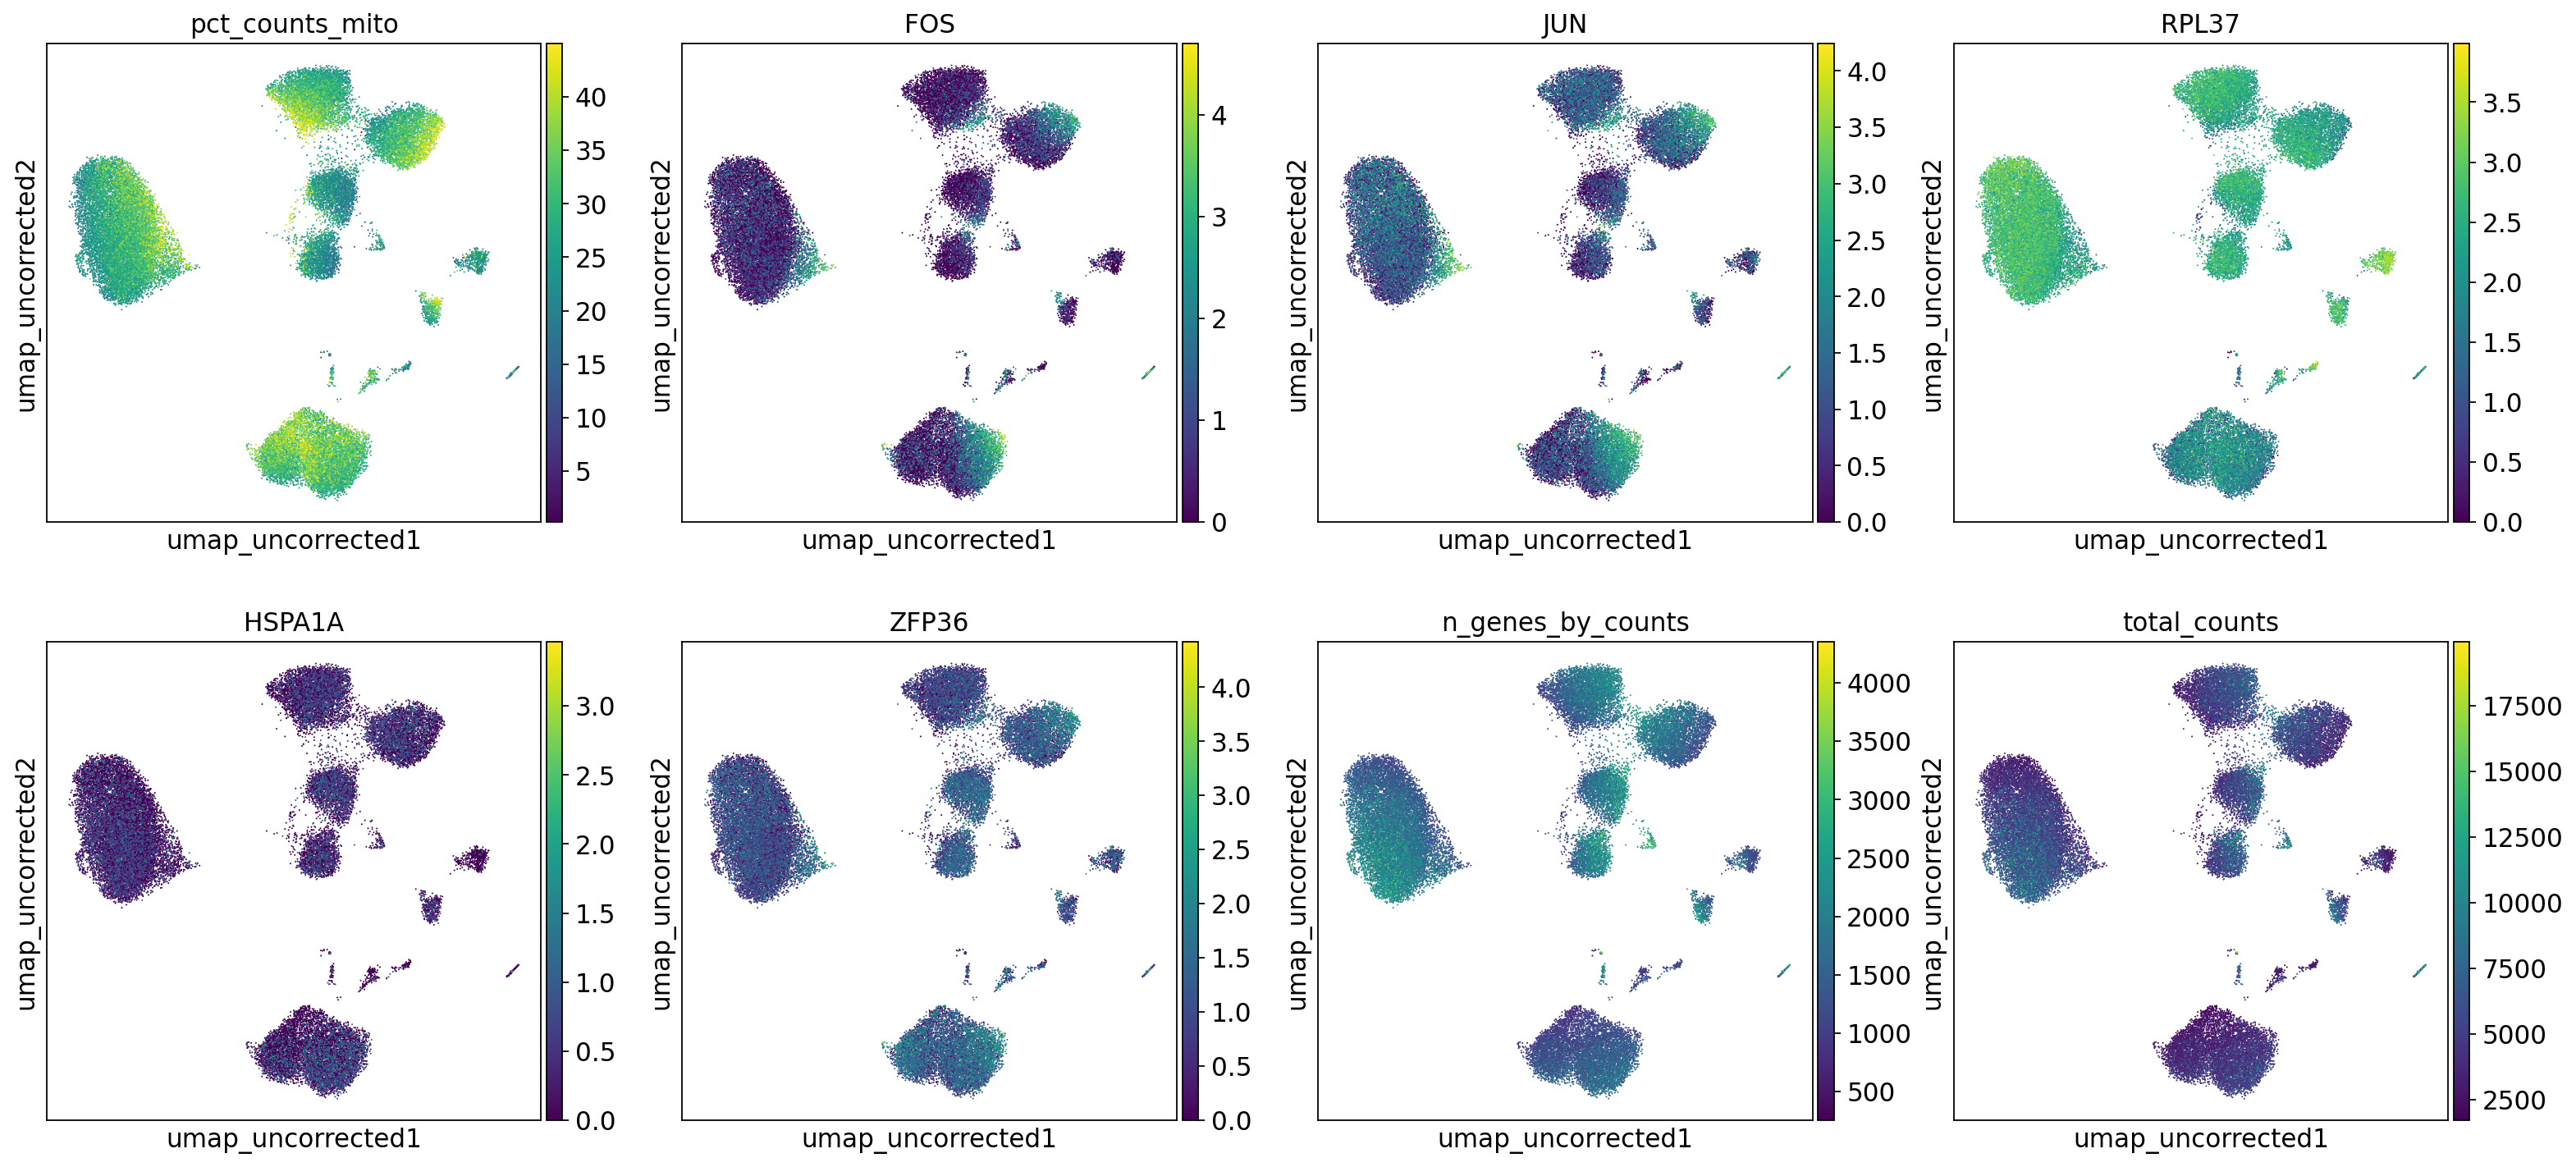

In [6]:
# plot fos/jun markers and covariates
sc.pl.embedding(
    adata,
    basis="umap_uncorrected",
    color=[
        "pct_counts_mito",
        "FOS",
        "JUN",
        "RPL37",
        "HSPA1A",
        "ZFP36",
        "n_genes_by_counts",
        "total_counts",
    ],
)

# Top Genes healhty vs malignant B cell

In [7]:
de_genes = pd.read_csv(
    "../../data/50_de_analysis/deseq2_results/deseq2_res_bulk_healthy_malignant/healthy_b_cell_malignant_b_cell_IHWallGenes.tsv",
    sep="\t",
)

In [8]:
top_genes = (
    de_genes.assign(
        direction=lambda x: ["up" if _ > 0 else "down" for _ in x["log2FoldChange"]]
    )
    .groupby("direction")
    .apply(lambda x: x.head(15))
)

In [9]:
pb_b_cells = sh.pseudobulk.pseudobulk(
    adata[adata.obs["cell_type"].isin(["malignant B cell", "healthy B cell"]), :],
    layer="raw_counts",
    groupby=["patient", "cell_type"],
)

In [10]:
sc.pp.normalize_total(pb_b_cells, target_sum=1e6)

In [11]:
sc.pp.log1p(pb_b_cells, base=2)

## Matrixplot with zscores

In [12]:
pb_b_cells.layers["z_scores"] = scipy.stats.zscore(pb_b_cells.X, axis=0)

/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'patient' as categorical
/data/scratch/sturm/conda/envs/2021-hairy-cell-leukemia-wolf-scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical


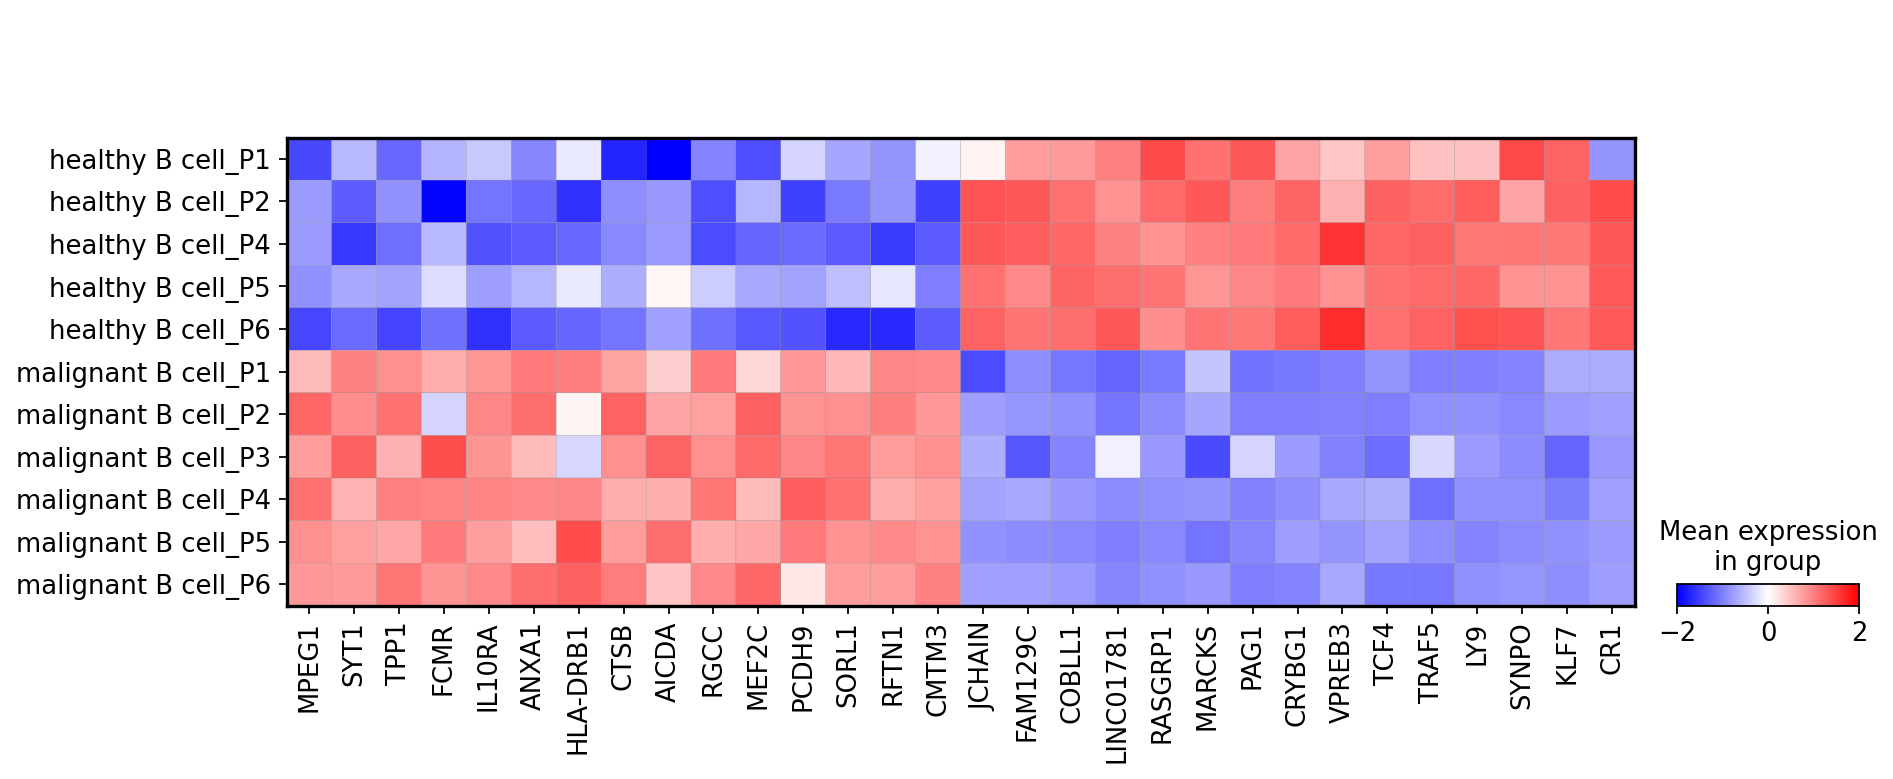

In [13]:
fig = sc.pl.matrixplot(
    pb_b_cells,
    var_names=top_genes["gene_id"],
    groupby=["cell_type", "patient"],
    cmap="bwr",
    vmin=-2,
    vmax=2,
    layer="z_scores",
    return_fig=True
)
fig.savefig(f"{artifact_dir}/healthy_malignant_b_cells_pseudobulk_zscore_heatmap.pdf", bbox_inches="tight")

### fold change plot

In [14]:
top_genes

gene_id      baseMean  log2FoldChange     lfcSE       stat  \
direction                                                                    
down      24      MPEG1   1347.884386       -2.164593  0.163953 -13.202534   
          37       SYT1    544.627654       -3.611922  0.331959 -10.880621   
          41       TPP1   1433.171231       -1.972074  0.183787 -10.730228   
          45       FCMR   3982.682852       -1.237029  0.117756 -10.504985   
          49     IL10RA    858.711650       -2.314778  0.224291 -10.320407   
          53      ANXA1    567.020545       -4.202169  0.420666  -9.989319   
          56   HLA-DRB1  12280.636704       -1.421775  0.145076  -9.800191   
          57       CTSB    692.026682       -2.426415  0.247699  -9.795835   
          59      AICDA    576.240485       -3.804648  0.390635  -9.739648   
          63       RGCC    689.980278       -3.688281  0.384541  -9.591392   
          64      MEF2C   1571.161169       -1.565023  0.164114  -9.536176   
          66      PCDH9   1243.864951       -2.483661  0.261804  -9.486723   
          67      SORL1    568.733852       -3.380499  0.357449  -9.457294   
          68      RFTN1    634.918014       -2.810391  0.297976  -9.431611   
          69      CMTM3    341.883909       -3.415721  0.365945  -9.333978   
up        0      JCHAIN    360.843108        6.904980  0.210982  32.727837   
          1     FAM129C    444.406146        7.092070  0.262398  27.027882   
          2      COBLL1    130.274810        7.716855  0.339937  22.700827   
          3   LINC01781    237.420641        8.298305  0.370868  22.375337   
          4     RASGRP1    156.444346        8.139503  0.368823  22.068846   
          5      MARCKS    219.742814        5.530064  0.254037  21.768712   
          6        PAG1     82.760564        7.924590  0.418290  18.945189   
          7      CRYBG1    105.879841        6.843632  0.370016  18.495483   
          8      VPREB3     77.727237        7.412540  0.405461  18.281737   
          9        TCF4    302.161912        6.148371  0.344001  17.873120   
          10      TRAF5    129.651004        4.847662  0.291757  16.615426   
          11        LY9     59.021948        8.181415  0.501191  16.323932   
          12      SYNPO     63.931069        8.251796  0.518404  15.917700   
          13       KLF7     69.147891        5.027132  0.318020  15.807602   
          14        CR1     46.003827        8.073476  0.525006  15.377874   

                     pvalue           padj    weight  gene_name  \
direction                                                         
down      24   8.483248e-40   2.681049e-37  2.020122      MPEG1   
          37   1.425878e-27   2.964705e-25  2.020122       SYT1   
          41   7.341512e-27   1.343677e-24  2.180172       TPP1   
          45   8.193614e-26   1.566661e-23  1.814692       FCMR   
          49   5.698094e-25   8.902239e-23  2.043245     IL10RA   
          53   1.697443e-23   2.764769e-21  1.814692      ANXA1   
          56   1.123728e-22   1.588968e-20  1.980301   HLA-DRB1   
          57   1.173236e-22   1.630370e-20  1.980301       CTSB   
          59   2.042610e-22   2.743866e-20  1.980301      AICDA   
          63   8.690475e-22   1.111813e-19  1.980301       RGCC   
          64   1.481969e-21   1.837615e-19  1.980301      MEF2C   
          66   2.384102e-21   3.177154e-19  1.814692      PCDH9   
          67   3.160144e-21   3.630260e-19  2.043245      SORL1   
          68   4.038366e-21   4.284754e-19  2.180172      RFTN1   
          69   1.019702e-20   1.066460e-18  2.180172      CMTM3   
up        0   6.276964e-235  5.520862e-231  1.814692     JCHAIN   
          1   6.951652e-161  2.746253e-157  2.020122    FAM129C   
          2   4.396507e-114  1.153654e-110  2.027548     COBLL1   
          3   6.843910e-111  1.252604e-107  2.180172  LINC01781   
          4   6.297818e-108  1.015194e-104  1.980301    RASGRP1   
          5   4.593596e-105  5.980552e-102  2

In [15]:
ch = sh.pairwise.plot_paired_fc(
    pb_b_cells[:, top_genes["gene_id"]],
    groupby="cell_type",
    paired_by="patient",
    metric="diff",
    de_res_df=top_genes,
    metric_name="log2(fold change)"
)

/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:50: UserWarning: You are plotting more than 20 variables which may be slow. Explicitly set the `var_names` parameter to turn this off. 
  warnings.warn(
/home/sturm/projects/2021/hairy_cell_leukemia_wolf/lib/scanpy_helpers/scanpy_helpers/pairwise.py:79: UserWarning: 1 unpaired samples removed
  warnings.warn(f"{removed_samples} unpaired samples removed")


In [16]:
ch.display()

alt.LayerChart(...)

In [17]:
ch.save(f"{artifact_dir}/healthy_malignant_b_cells_pseudobulk_fold_changes.svg")